# Supernova Distances and Redshift part 2


## Part 1
First let's fit our supernova synthetic data from last time using GPR.

- The key ingrediente in getting a good GPR fit is the choice of the kernel and its parameters.
- Check out what's available in the `kernels` submodule of [sklearn.gaussian_process](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.gaussian_process)
- *Hint*. Radial-basis function kernel (aka squared-exponential kernel) is a standard choice in the GPR world.
- Plot the expectation value of the fit as well as the resulting 1-$\sigma$ and 2-$\sigma$ contours.
- Interpret the results.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from astroML.datasets import generate_mu_z
from sklearn.gaussian_process import GaussianProcessRegressor, kernels
from astropy.cosmology import FlatLambdaCDM

import dynesty
from dynesty import plotting as dyplot
from dynesty import utils as dyfunc

import corner


plt.rcParams['figure.figsize'] = [8, 8]
plt.rcParams['font.size'] = 15

(35, 50)

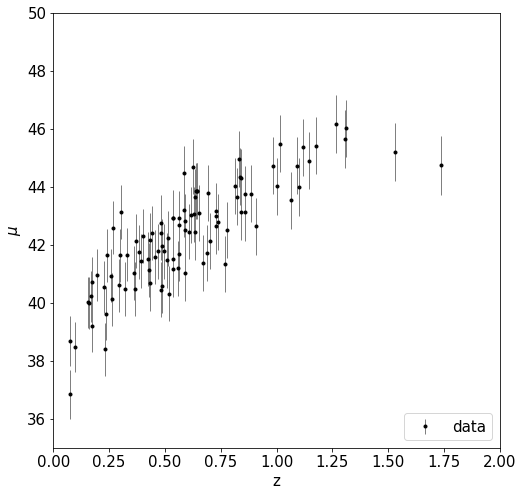

In [2]:
#Download and plot the data

z_sample, mu_sample, dmu = generate_mu_z(100, random_state=1234)

plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='data')
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.legend(loc='lower right')
plt.xlim(0,2)
plt.ylim(35,50)

## Gaussian Process Regression

In [3]:
kernel = 1*kernels.RBF(1, (1e-2,1e2)) 
gpr = GaussianProcessRegressor(kernel=kernel, alpha=(dmu)**2)

x_grid = np.linspace(0.0, 2.0, 100)

gpr.fit(z_sample[:, np.newaxis], mu_sample)
mean_pred, std_pred = gpr.predict(x_grid[:, np.newaxis], return_std=True)

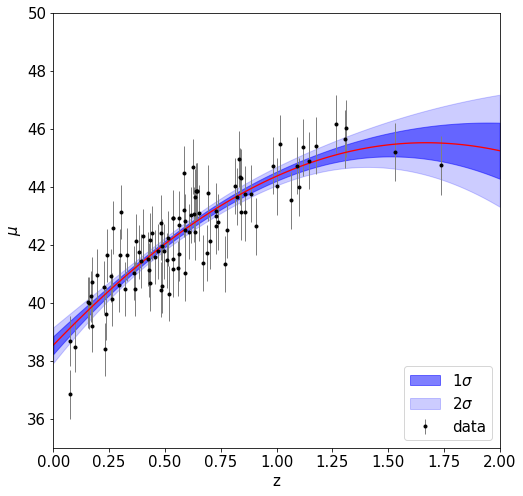

In [4]:
#plot the fit

plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='data')

plt.fill_between(x_grid, mean_pred - 1 * std_pred, mean_pred + 1 * std_pred, 
                 color='b', alpha=0.5, label='1$\sigma$')
plt.fill_between(x_grid, mean_pred - 2 * std_pred, mean_pred + 2 * std_pred, 
                 color='b', alpha=0.2, label='2$\sigma$')

plt.plot(x_grid, mean_pred, color='red', lw=1.3)

plt.xlabel("z")
plt.ylabel("$\mu$")
plt.legend(loc='lower right')
plt.title('')
plt.xlim(0,2)
plt.ylim(35,50)
plt.show()

From the plot we can observe that for redshift z $\ge$ 1.25 we have an increase in the variance of the fit, this is due to the lower number of data present (this is also possible to see a little bit around reshifts z $\sim$ 0 and z $\sim$ 1.0. Otherwise for reshifts 0.25 $\le z \le$ 1.0 the fit presents the minimum of the variance, because here are present the majority of the data. 

## Part 2
We now have a suite of *data-drive predictive models* for our supernova dataset. That is: we can faithfully predict how a future redshift/distance measurement will look like given the current sample.

This is already great and these kind of tools are immensely useful in a variety of contexts (also involving a lot of money: suppose you want to predict how much a give financial asset will perform on tomorrow's stock market... You  might not really care about expressing the underlying financial model in simple terms, as long as your investments are profitable).

For the case of supernovae, however, we have do have physical theory which is $\Lambda$CDM.

- First, refresh your cosmology and write down the predicted relationship between the distance module $\mu$ and the redshift $\sigma$. *Hint* I always forget these things, my to-go reference is [Hogg (2010)](https://arxiv.org/abs/astro-ph/9905116). I got:

$$\mu = 5 \log \left( \frac{c/H_0} {10 {\rm pc}}(1+z)\int_0^z \frac{dz'}{\sqrt{\Omega_m (1+z^3)+\Omega_\Lambda}} \right) $$


- Assuming a flat Universe,  we have a parametric non-linear model for $\mu(z)$ that depends on two parameters, the Hubble constant $H_0$ and the matter content of the Universe $\Omega_m$
- It's a very non-linear model. Fit it to the data (however you want to do it).
- What are the measured value of $H_0$ and $\Omega_m$. Are they correlated?
- How would a model without dark energy (i.e. $\Omega_m=1$) perform? Do these data contain evidence of dark energy? (Hint: this is a model selection problem!)

The European Space Agency is considering new cosmology-related space mission. They ask you to figure out what science you can do with 10 times more measurement compared to what you have right now. That is: you want to clone your data. We've seen this earlier in the class, but now we can do much better.
- Assume a uniform distribution in redshifts between 0 and z.
- Using both the GPR fit and your latest $\Lambda$CDM fit, generate a set of $\mu$ measurements that respects the statistical properties of the data you were given. 

We take the $\Lambda$CDM model from Astropy.

In [5]:
#model
def model(par, z):
    H0, Om0 = par 
    
    #flat model
    cosmo = FlatLambdaCDM(H0=H0, Om0=Om0) 
    
    #distance modulus
    mu = cosmo.distmod(z).value
    return mu

We fit our data with the theoretical model.

/home/federica/anaconda/lib/python3.7/site-packages/astropy/cosmology/core.py:1495: RuntimeWarning: divide by zero encountered in log10
  val = 5. * np.log10(abs(self.luminosity_distance(z).value)) + 25.0


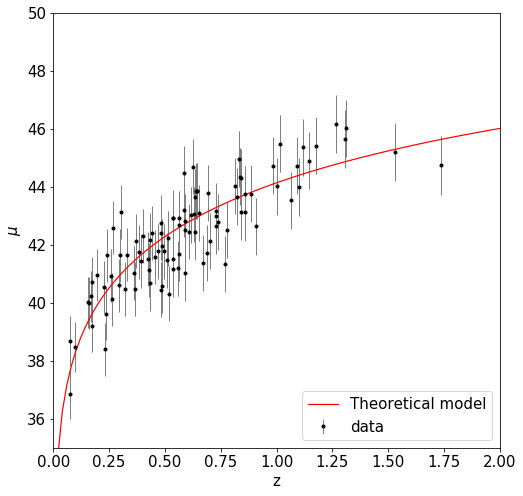

In [6]:
#theoretical model that fit our data
x_grid = np.linspace(0.0, 2.0, 100)

#values of H0 and Om0 from theory
param = [70, 0.27] 

#fit the parameters to the model
fit = model(param, x_grid)


#plot of the model with the data
plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='data')
plt.plot(x_grid, fit, color='red', lw=1.2, label='Theoretical model')

plt.xlabel("z")
plt.ylabel("$\mu$")
plt.legend(loc='lower right')
plt.xlim(0,2)
plt.ylim(35,50)
plt.show()

## Nested Sampling

We have a model which depends on two parameters and the data. To fit our data we can try to use Nested Sampling.

In [7]:
ndim = 2

#we want to find the parameters
def prior(x):
    H0 = x[0]*200
    Om0 = x[1]
    
    par = np.array([H0, Om0])
    return par

def loglike(par):
    mu_fit = model(par, z_sample)
    return -0.5 * np.sum((mu_sample - mu_fit)**2/(dmu**2)) 

In [8]:
#nested sampling

sampler = dynesty.NestedSampler(loglike, prior, ndim)
sampler.run_nested()
sresults = sampler.results

2237it [00:27, 81.85it/s, +500 | bound: 2 | nc: 1 | ncall: 19350 | eff(%): 14.520 | loglstar:   -inf < -46.385 <    inf | logz: -50.004 +/-  0.068 | dlogz:  0.001 >  0.509]


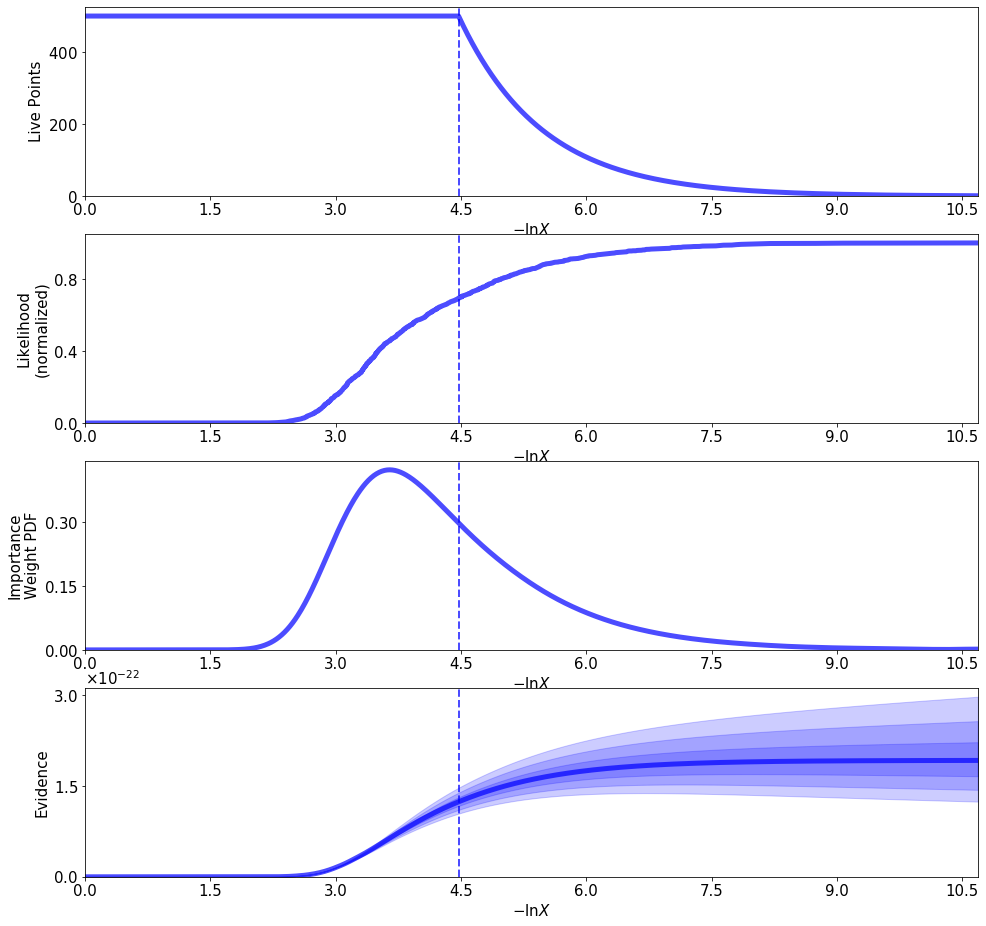

In [9]:
# Plot a summary of the run.
rfig, raxes = dyplot.runplot(sresults)

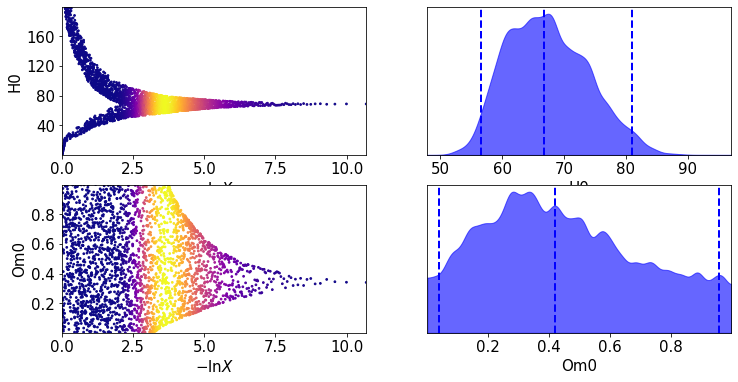

In [10]:
label_model = ['H0', 'Om0']

tfig, taxes = dyplot.traceplot(sresults, labels=label_model)

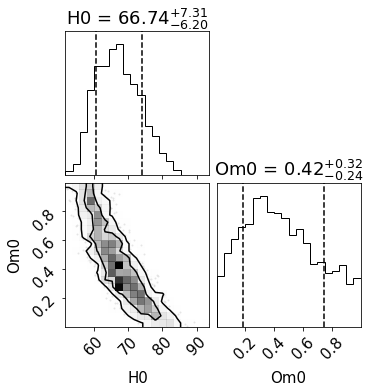

In [11]:
#extract the samples and find the weights
samples = sresults.samples  # samples
weights = np.exp(sresults.logwt - sresults.logz[-1])  # normalized weights

# Resample weighted samples
samples_equal = dyfunc.resample_equal(samples, weights)

#make a cornerplot
corner.corner(samples_equal, labels=label_model, levels=[0.68,0.95], quantiles=[0.16, 0.84], show_titles=True);

In [12]:
median = np.empty(ndim)
quantile_95 = np.empty(ndim) 
quantile_05 = np.empty(ndim) 

for i in range(ndim):
    median[i] = np.median(samples_equal[:, i])
    quantile_95[i] = np.quantile(samples_equal[:, i], 0.95)
    quantile_05[i] = np.quantile(samples_equal[:, i], 0.05)
    
    up = quantile_95[i] - median[i]
    low = median[i] - quantile_05[i]
    
    print(label_model[i],'=', str(round(median[i], 2)),'+', str(round(up, 2)), '-', str(round(low, 2)))

H0 = 66.74 + 11.9 - 8.89
Om0 = 0.42 + 0.49 - 0.35


Now we take a look at the posterior spread of the model.

/home/federica/anaconda/lib/python3.7/site-packages/astropy/cosmology/core.py:1495: RuntimeWarning: divide by zero encountered in log10
  val = 5. * np.log10(abs(self.luminosity_distance(z).value)) + 25.0


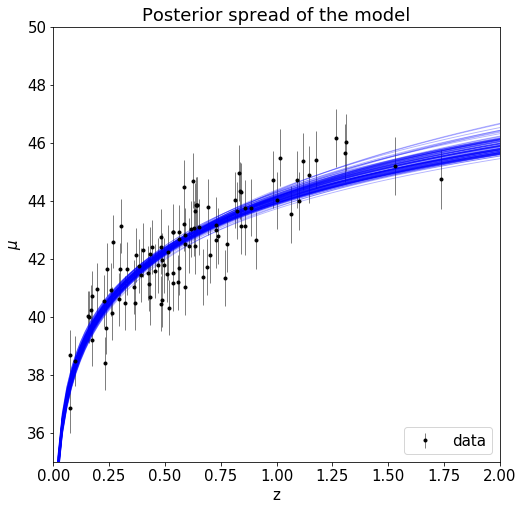

In [13]:
x_grid  = np.linspace(0.0, 2.0, 100)
data_sample = samples_equal[np.random.choice(range(len(samples_equal)), 100)]
model_post = np.array([model(par, x_grid) for par in data_sample])

for i in range(len(data_sample)):
    plt.plot(x_grid, model_post[i], alpha=0.3, lw=0.9, color='b')
    plt.title('Posterior spread of the model')
    

plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='data')
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.legend(loc='lower right')
plt.xlim(0,2)
plt.ylim(35,50)
plt.show()

The postirior spread seems to fit well the data, despite the big uncertainities.

## Model without Dark Energy

Now we consider a model without Dark Energy ($\Omega_{m}$ = 1).

In [14]:
#Om0 = 1 

ndim_noDE = 1

#model with no dark energy
def model_noDE(H0, Om0, z):
    
    #flat model
    cosmo = FlatLambdaCDM(H0=H0, Om0=1) 
    
    #distance modulus
    mu = cosmo.distmod(z).value
    return mu

We still use Nested Sampling alghoritm.

In [15]:
#we want to find the parameter
def prior_noDE(x):
    H0 = x[0]*200

    par = np.array([H0])
    return par

def loglike_noDE(par):
    H0 = float(par)
    Om0 = 1
    mu_fit_noDE = model_noDE(H0, Om0, z_sample)
    return -0.5 * np.sum((mu_sample - mu_fit_noDE)**2/(dmu**2)) 

In [16]:
#nested sampling

sampler_noDE = dynesty.NestedSampler(loglike_noDE, prior_noDE, ndim_noDE)
sampler_noDE.run_nested()
sresults_noDe = sampler_noDE.results

2169it [00:22, 95.07it/s, +500 | bound: 1 | nc: 1 | ncall: 18845 | eff(%): 14.549 | loglstar:   -inf < -47.102 <    inf | logz: -50.535 +/-  0.061 | dlogz:  0.001 >  0.509]


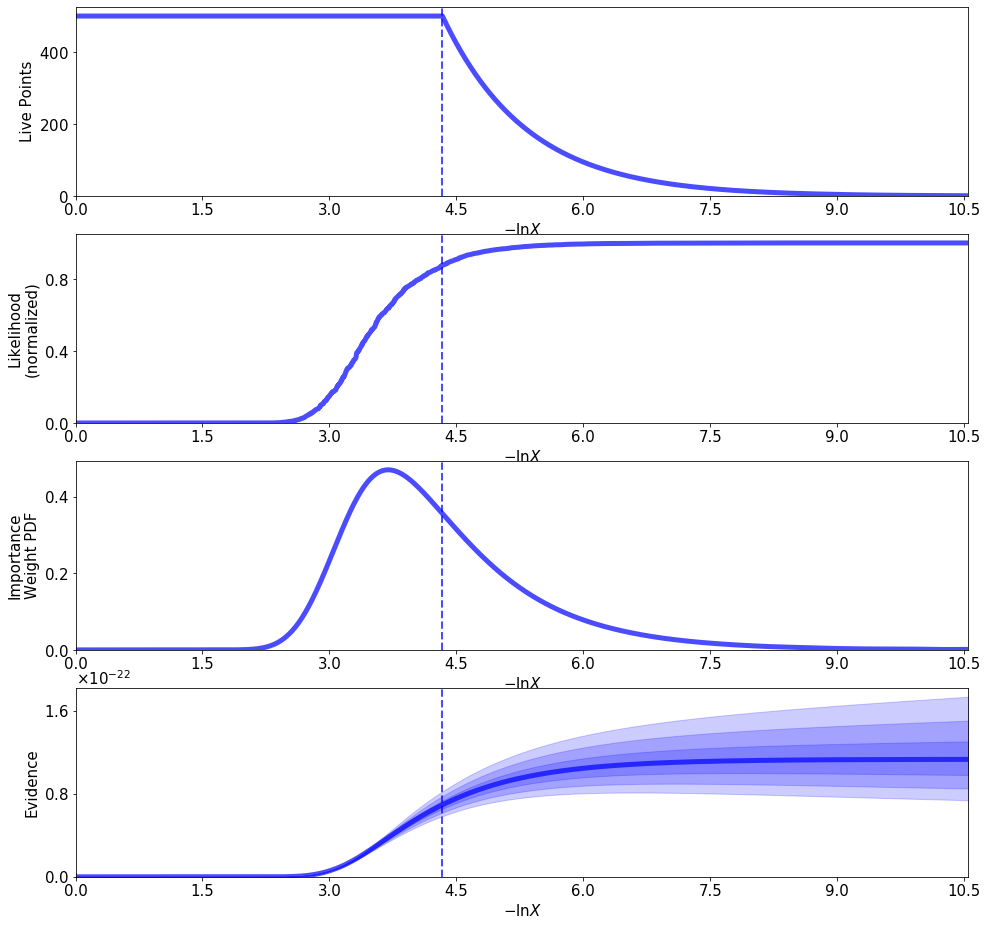

In [17]:
# Plot a summary of the run.
rfig, raxes = dyplot.runplot(sresults_noDe)

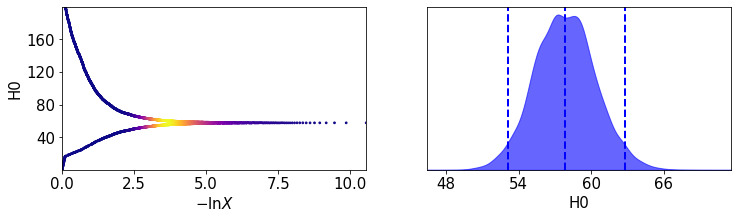

In [18]:
label_model = ['H0', 'Om0']

tfig, taxes = dyplot.traceplot(sresults_noDe, labels=label_model)

In [19]:
#We find the value of H0

#extract the samples and find the weights
samples_noDE = sresults_noDe.samples  # samples
weights_noDE = np.exp(sresults_noDe.logwt - sresults_noDe.logz[-1])  # normalized weights

# Resample weighted samples
samples_equal_noDE = dyfunc.resample_equal(samples_noDE, weights_noDE)

median = np.median(samples_equal_noDE)
quantile_95 = np.quantile(samples_equal_noDE, 0.95)
quantile_05 = np.quantile(samples_equal_noDE, 0.05)

up = quantile_95 - median
low = median - quantile_05
    
print('H0 =', str(round(median, 2)),'+', str(round(up, 2)), '-', str(round(low, 2)))

H0 = 57.8 + 4.25 - 3.98


We obtain that the value of $H_0$ is samller than the value of the full model.
Now we consider the postirior spread of this model in order to understand if it is a good fit or not.

/home/federica/anaconda/lib/python3.7/site-packages/astropy/cosmology/core.py:1495: RuntimeWarning: divide by zero encountered in log10
  val = 5. * np.log10(abs(self.luminosity_distance(z).value)) + 25.0
/home/federica/anaconda/lib/python3.7/site-packages/astropy/cosmology/core.py:1495: RuntimeWarning: divide by zero encountered in log10
  val = 5. * np.log10(abs(self.luminosity_distance(z).value)) + 25.0
/home/federica/anaconda/lib/python3.7/site-packages/astropy/cosmology/core.py:1495: RuntimeWarning: divide by zero encountered in log10
  val = 5. * np.log10(abs(self.luminosity_distance(z).value)) + 25.0
/home/federica/anaconda/lib/python3.7/site-packages/astropy/cosmology/core.py:1495: RuntimeWarning: divide by zero encountered in log10
  val = 5. * np.log10(abs(self.luminosity_distance(z).value)) + 25.0
/home/federica/anaconda/lib/python3.7/site-packages/astropy/cosmology/core.py:1495: RuntimeWarning: divide by zero encountered in log10
  val = 5. * np.log10(abs(self.luminosity_di

/home/federica/anaconda/lib/python3.7/site-packages/astropy/cosmology/core.py:1495: RuntimeWarning: divide by zero encountered in log10
  val = 5. * np.log10(abs(self.luminosity_distance(z).value)) + 25.0
/home/federica/anaconda/lib/python3.7/site-packages/astropy/cosmology/core.py:1495: RuntimeWarning: divide by zero encountered in log10
  val = 5. * np.log10(abs(self.luminosity_distance(z).value)) + 25.0
/home/federica/anaconda/lib/python3.7/site-packages/astropy/cosmology/core.py:1495: RuntimeWarning: divide by zero encountered in log10
  val = 5. * np.log10(abs(self.luminosity_distance(z).value)) + 25.0
/home/federica/anaconda/lib/python3.7/site-packages/astropy/cosmology/core.py:1495: RuntimeWarning: divide by zero encountered in log10
  val = 5. * np.log10(abs(self.luminosity_distance(z).value)) + 25.0
/home/federica/anaconda/lib/python3.7/site-packages/astropy/cosmology/core.py:1495: RuntimeWarning: divide by zero encountered in log10
  val = 5. * np.log10(abs(self.luminosity_di

/home/federica/anaconda/lib/python3.7/site-packages/astropy/cosmology/core.py:1495: RuntimeWarning: divide by zero encountered in log10
  val = 5. * np.log10(abs(self.luminosity_distance(z).value)) + 25.0
/home/federica/anaconda/lib/python3.7/site-packages/astropy/cosmology/core.py:1495: RuntimeWarning: divide by zero encountered in log10
  val = 5. * np.log10(abs(self.luminosity_distance(z).value)) + 25.0
/home/federica/anaconda/lib/python3.7/site-packages/astropy/cosmology/core.py:1495: RuntimeWarning: divide by zero encountered in log10
  val = 5. * np.log10(abs(self.luminosity_distance(z).value)) + 25.0
/home/federica/anaconda/lib/python3.7/site-packages/astropy/cosmology/core.py:1495: RuntimeWarning: divide by zero encountered in log10
  val = 5. * np.log10(abs(self.luminosity_distance(z).value)) + 25.0
/home/federica/anaconda/lib/python3.7/site-packages/astropy/cosmology/core.py:1495: RuntimeWarning: divide by zero encountered in log10
  val = 5. * np.log10(abs(self.luminosity_di

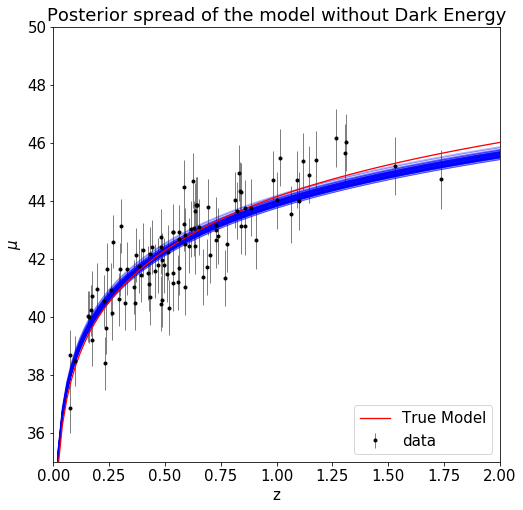

In [20]:
x_grid  = np.linspace(0.0, 2.0, 100)
data_sample_noDE = samples_equal_noDE[np.random.choice(range(len(samples_equal_noDE)), 100)]

for H0 in data_sample_noDE:
    model_post_noDE = model_noDE(float(H0), 1, x_grid)
    plt.plot(x_grid, model_post_noDE, alpha=0.3, lw=0.9, color='b')
    plt.title('Posterior spread of the model without Dark Energy')
    

plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='data')
plt.plot(x_grid, fit, color='red', alpha=1, lw=1.3, label='True Model' )
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.legend(loc='lower right')
plt.xlim(0,2)
plt.ylim(35,50)
plt.show()

From the plot we can observe that even this model without dark energy can fit well our data. We can compare the two models with Bayes factor to see which is the best one.

In [21]:
#Bayes Factor

evidence = np.exp(sresults.logz[-1])
evidence_noDE = np.exp(sresults_noDe.logz[-1])

bayes_factor = evidence/evidence_noDE
print('The Bayes factor is:', bayes_factor)

The Bayes factor is: 1.6996558237345627


From the Bayes factor we can not say with certainity which model is the best one. We can try to improve by fixing $H_0$=70 km/s/Mpc instead of $\Omega_m$.

In [22]:
ndim_H0 = 1

#model
def model_H0(H0, Om0, z):
    
    #flat model
    cosmo = FlatLambdaCDM(H0=70, Om0=Om0) 
    
    #distance modulus
    mu = cosmo.distmod(z).value
    return mu

#we want to find the parameter
def prior_H0(x):
    Om0 = x[0]

    par = np.array([Om0])
    return par

def loglike_H0(par):
    H0 = 70
    Om0 = float(par)
    mu_fit_H0 = model_H0(H0, Om0, z_sample)
    return -0.5 * np.sum((mu_sample - mu_fit_H0)**2/(dmu**2)) 

In [23]:
#nested sampling

sampler_H0 = dynesty.NestedSampler(loglike_H0, prior_H0, ndim_H0)
sampler_H0.run_nested()
sresults_H0 = sampler_H0.results

1147it [00:08, 133.62it/s, +500 | bound: 0 | nc: 1 | ncall: 5227 | eff(%): 34.842 | loglstar:   -inf < -46.399 <    inf | logz: -47.787 +/-    nan | dlogz:  0.001 >  0.509]


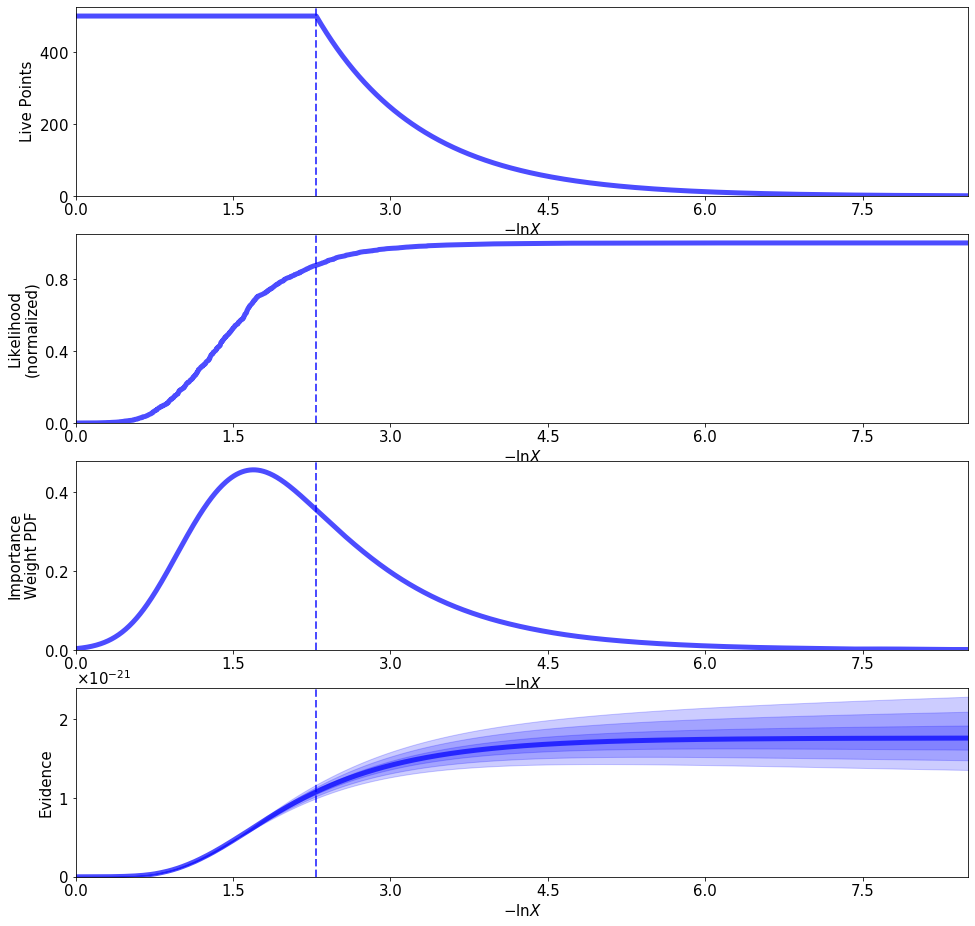

In [24]:
# Plot a summary of the run.
rfig, raxes = dyplot.runplot(sresults_H0)

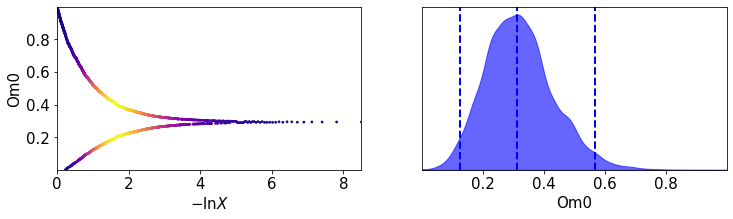

In [25]:
label_model = ['Om0']

tfig, taxes = dyplot.traceplot(sresults_H0, labels=label_model)

In [26]:
#We find the value of Om0

#extract the samples and find the weights
samples_H0 = sresults_H0.samples  # samples
weights_H0 = np.exp(sresults_H0.logwt - sresults_H0.logz[-1])  # normalized weights

# Resample weighted samples
samples_equal_H0 = dyfunc.resample_equal(samples_H0, weights_H0)

median = np.median(samples_equal_H0)
quantile_95 = np.quantile(samples_equal_H0, 0.95)
quantile_05 = np.quantile(samples_equal_H0, 0.05)

up = quantile_95 - median
low = median - quantile_05
    
print('Om0 =', str(round(median, 2)),'+', str(round(up, 2)), '-', str(round(low, 2)))

Om0 = 0.31 + 0.21 - 0.16


/home/federica/anaconda/lib/python3.7/site-packages/astropy/cosmology/core.py:1495: RuntimeWarning: divide by zero encountered in log10
  val = 5. * np.log10(abs(self.luminosity_distance(z).value)) + 25.0
/home/federica/anaconda/lib/python3.7/site-packages/astropy/cosmology/core.py:1495: RuntimeWarning: divide by zero encountered in log10
  val = 5. * np.log10(abs(self.luminosity_distance(z).value)) + 25.0
/home/federica/anaconda/lib/python3.7/site-packages/astropy/cosmology/core.py:1495: RuntimeWarning: divide by zero encountered in log10
  val = 5. * np.log10(abs(self.luminosity_distance(z).value)) + 25.0
/home/federica/anaconda/lib/python3.7/site-packages/astropy/cosmology/core.py:1495: RuntimeWarning: divide by zero encountered in log10
  val = 5. * np.log10(abs(self.luminosity_distance(z).value)) + 25.0
/home/federica/anaconda/lib/python3.7/site-packages/astropy/cosmology/core.py:1495: RuntimeWarning: divide by zero encountered in log10
  val = 5. * np.log10(abs(self.luminosity_di

/home/federica/anaconda/lib/python3.7/site-packages/astropy/cosmology/core.py:1495: RuntimeWarning: divide by zero encountered in log10
  val = 5. * np.log10(abs(self.luminosity_distance(z).value)) + 25.0
/home/federica/anaconda/lib/python3.7/site-packages/astropy/cosmology/core.py:1495: RuntimeWarning: divide by zero encountered in log10
  val = 5. * np.log10(abs(self.luminosity_distance(z).value)) + 25.0
/home/federica/anaconda/lib/python3.7/site-packages/astropy/cosmology/core.py:1495: RuntimeWarning: divide by zero encountered in log10
  val = 5. * np.log10(abs(self.luminosity_distance(z).value)) + 25.0
/home/federica/anaconda/lib/python3.7/site-packages/astropy/cosmology/core.py:1495: RuntimeWarning: divide by zero encountered in log10
  val = 5. * np.log10(abs(self.luminosity_distance(z).value)) + 25.0
/home/federica/anaconda/lib/python3.7/site-packages/astropy/cosmology/core.py:1495: RuntimeWarning: divide by zero encountered in log10
  val = 5. * np.log10(abs(self.luminosity_di

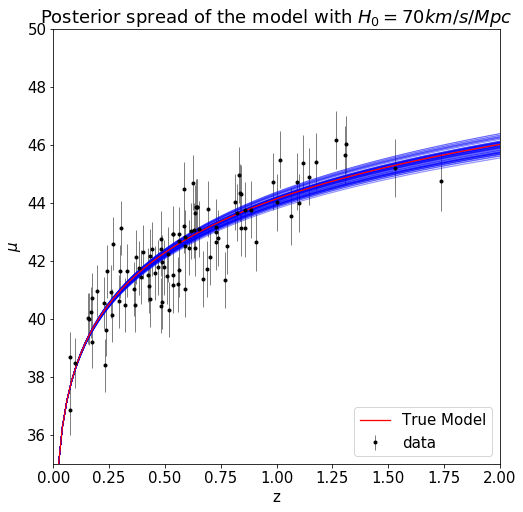

In [29]:
x_grid  = np.linspace(0.0, 2.0, 100)
data_sample_H0 = samples_equal_H0[np.random.choice(range(len(samples_equal_H0)), 100)]

for Om0 in data_sample_H0:
    model_post_H0 = model_H0(70, float(Om0), x_grid)
    plt.plot(x_grid, model_post_H0, alpha=0.3, lw=0.9, color='b')
    plt.title(r'Posterior spread of the model with $H_0 = 70 km/s/Mpc$')
    

plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='data')
plt.plot(x_grid, fit, color='red', alpha=1, lw=1.3, label='True Model' )
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.legend(loc='lower right')
plt.xlim(0,2)
plt.ylim(35,50)
plt.show()

In [30]:
#Bayes Factor

evidence_H0 = np.exp(sresults_H0.logz[-1])
evidence_noDE = np.exp(sresults_noDe.logz[-1])

bayes_factor = evidence_H0/evidence_noDE
print('The Bayes factor is:', bayes_factor)

The Bayes factor is: 15.603034623207147


From the Bayes factor we can say that we obtain a better fit with the model with fixed $H_0 = 70 km/s/Mpc$.

## Clone Data

The European Space Agency is considering new cosmology-related space mission. They ask you to figure out what science you can do with 10 times more measurement compared to what you have right now. That is: you want to clone your data. We've seen this earlier in the class, but now we can do much better.
- Assume a uniform distribution in redshifts between 0 and z.
- Using both the GPR fit and your latest $\Lambda$CDM fit, generate a set of $\mu$ measurements that respects the statistical properties of the data you were given. 

In [39]:
N = 10000

#print(max(z_sample))

clone_data = np.random.uniform(0.0, 2.0, N)
mu_model = []
mu_gpr = []
mu_noDE = []

for i in clone_data:
    param = samples_equal[np.random.choice(samples_equal.shape[0])]
    mu_model.append(model(param, i))
    
    param_noDE = samples_equal[(np.random.choice(samples_equal_noDE.shape[0]))]
    mu_noDE.append(model_noDE(param_noDE[0], 1,  i))
    
    mu_fit, sigma = gpr.predict([[i]], return_std=True)
    mu_gpr.append(np.random.normal(loc=mu_fit, scale=sigma))

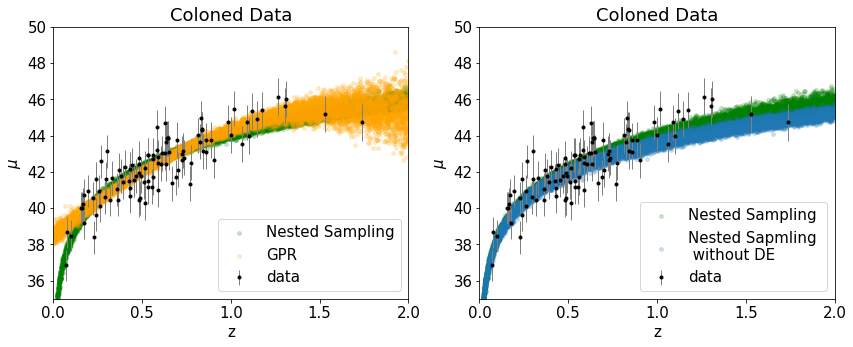

In [50]:
fig = plt.figure(figsize=(14,5))

ax = fig.add_subplot(121)

plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='data')

plt.scatter(clone_data, mu_model, alpha=0.2, color='green', s=14, label='Nested Sampling')
plt.scatter(clone_data, mu_gpr, alpha=0.2, color='orange', s=14, label='GPR')

plt.xlabel("z")
plt.ylabel("$\mu$")
plt.title('Coloned Data')
plt.legend(loc='lower right')
plt.xlim(0,2)
plt.ylim(35,50)


ax = fig.add_subplot(122)

plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='data')

plt.scatter(clone_data, mu_model, alpha=0.2, color='green', s=14, label='Nested Sampling')
plt.scatter(clone_data, mu_noDE, alpha=0.2, color='C0', s=14, label='Nested Sapmling \n without DE')

plt.xlabel("z")
plt.ylabel("$\mu$")
plt.title('Coloned Data')
plt.legend(loc='lower right')
plt.xlim(0,2)
plt.ylim(35,50)
plt.show()

By observing the plots we can see that data generated from GPR present an increase in variance as the redshift increase. Otherwise the data generated from the Nested Sampling do not present this increase in variance (they present a smaller spread).